# Notes on Transformation Matrix Using `numpy`/`scipy`

Transformation Matrix တွေဟာ Application တွေ အများအပြားရှိပေမဲ့ မြင်သာထင်သာ အရှိဆုံး Application ကတော့ Image Registration ပဲ ဖြစ်ပါတယ်



## Image Registration

**Image Registration** ဆိုတာ တူညီတဲ့ အရာတခုတည်းရဲ့ မတူညီတဲ့ ပုံရိပ်တွေကို ပုံတခုတည်းဖြစ်အောင် ပြန်လည်ပေါင်းစပ်တဲ့ နည်းပညာဖြစ်ပါတယ်။ အရပ်သုံး ဗန်းစကားနဲ့ဆိုရင်တော့ **ဖြတ်ညှပ်**ထားတာတွေကို ပြန်**က**ပ်တဲ့ **ဖြတ်ညှပ်ကပ်** သဘောတရားပေါ့။

လက်ကိုင်ဖုန်းနဲ့ ဖြစ်ဖြစ်၊ ကင်မရာနဲ့ဖြစ်ဖြစ် panaroma ဓာတ်ပုံရိုက်ဖူးရင် **Image Registration** ကို လက်တွေ့ အသုံးပြုဖူးတယ်လို့ ဆိုရမယ်။

In [ ]:
# 1st, built-ins
import requests
from io import BytesIO

# 2nd, third-parties
import numpy as np
import scipy as sp
from scipy import linalg as la

from matplotlib import pyplot as plt
from PIL import Image

import cv2

### Obtaining some Images 

အရင်ဆုံး လေ့ကျင့်ခန်းမှာသုံးဖို့ ပုံအကြီးကြီး တပုံကို ရယူရအောင်။ 

> ![Standford Oval](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Stanford_Oval_May_2011_panorama.jpg/1024px-Stanford_Oval_May_2011_panorama.jpg)
> King of Hearts / Wikimedia Commons / CC-BY-SA-3.0, CC BY-SA 3.0 \<https://creativecommons.org/licenses/by-sa/3.0\>, via Wikimedia Commons
> အပေါ်ကပုံကို [ဒီလင့်ခ်](https://upload.wikimedia.org/wikipedia/commons/c/cd/Stanford_Oval_May_2011_panorama.jpg) ကနေ ရယူပါတယ်။ 

အပေါ်ကပုံက ကြီးလွန်းတယ်၊ ဒါကြောင့် ဒီပုံအကြီးကြီးကို download ဆွဲပြီး အလယ်ပိုင်းက ပုံလေးကို ဖြတ်ယူကြရအောင်။ 

နောက်ဆက်သုံးဖို့ လိုတာတွေအတွက် တတန်းတည်း ဖြစ်မနေတဲ့ အနီစက်ကလေး ၄ စက်ရယ်၊ အပြာစက်ကလေး ၄ စက်ရယ်ကိုလဲ ထည့်လိုက်မယ်။



In [ ]:
# We will take a cached image (large one) of that picture first.
r = requests.get("https://i.ibb.co/mB8c3XK/Stanford-Oval-May-2011-panorama.jpg", allow_redirects=True)
with BytesIO(r.content) as f:
  raw_img = Image.open(f)
  img = np.array(raw_img)

img ... 


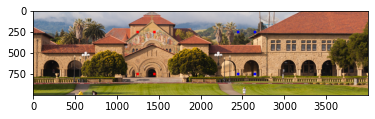

In [ ]:
# cv2 image has Y before X
Y = 0
X = 1

# crop start point of the center image is (1000, 4000) 
# and width/height of the center image is 4000/1000
CROP_X = 4000
CROP_Y = 1000
CROP_HEIGHT = 1000
CROP_WIDTH = 4000

# cropping to get the center portion of the image
# cropping is done by simple numpy slicing/indexing
img = img[CROP_Y:CROP_Y+CROP_HEIGHT, CROP_X:CROP_X+CROP_WIDTH, :]

# now, we will put 4 red rectangles
img[235:265, 1235:1265, :] = [255, 0, 0]
img[235:265, 1435:1465, :] = [255, 0, 0]
img[735:765, 1235:1265, :] = [255, 0, 0]
img[735:765, 1435:1465, :] = [255, 0, 0]

# and 4 blue rectangles
img[235:265, 2435:2465, :] = [0, 0, 255]
img[235:265, 2635:2665, :] = [0, 0, 255]
img[735:765, 2435:2465, :] = [0, 0, 255]
img[735:765, 2635:2665, :] = [0, 0, 255]

print ("img ... ")
plt.imshow(img)
plt.show()


ပြီးတော့ လေ့ကျင့်ခန်းမှာ သုံးဖို့ အလယ်ပိုင်းနားက ပုံ ၃ ပုံ crop လုပ်ယူကြရအောင်။ 

ဒီအတိုင်း လေးထောင့်တုံးကြီးတွေ ဖြတ်ယူရင် ပျင်းစရာကောင်းလို့ random rotate လေးလဲ လုပ်ကြမယ်။ 

ရလာတဲ့ ပုံ ၃ ပုံမှာ ဘယ်ဘက်ပုံမှာ အနီစက် ၄ စက်၊ ညာဘက်ပုံမှာ အပြာစက် ၄ စက်၊ အလယ်ပုံမှာ အနီစက် ၄ စက်ရော၊ အပြာစက် ၄ စက်ရော ပါလာတာ မြင်ရလိမ့်မယ်။

3 images ... 


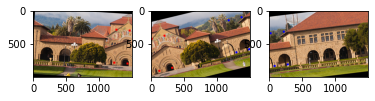

In [ ]:
# width and height of each of the 3 images is 1500 x 1000
WIDTH = 1500
HEIGHT = 1000

# starting X of each of the 3 images is 0, 1200, 2400
START_XS = np.array([0, 1200, 2400])

# random angles between -15 degree to +15 degree
np.random.seed(42)
random_angle_0 = (np.random.random() * 2 - 1.0) * 15 
random_angle_1 = (np.random.random() * 2 - 1.0) * 15 
random_angle_2 = (np.random.random() * 2 - 1.0) * 15 

# creating rotation Matrices from random angles
center = np.array([WIDTH//2, HEIGHT//2])
M_Rotate_0 = cv2.getRotationMatrix2D(tuple(center + np.array([START_XS[0], 0])), random_angle_0, 1.0)
M_Rotate_1 = cv2.getRotationMatrix2D(tuple(center + np.array([START_XS[1], 0])), random_angle_1, 1.0)
M_Rotate_2 = cv2.getRotationMatrix2D(tuple(center + np.array([START_XS[2], 0])), random_angle_2, 1.0)

# we will create 3 overlapping images with some random rotation
img_0 = cv2.warpAffine(img, M_Rotate_0, (CROP_WIDTH, CROP_HEIGHT))[:, START_XS[0]:START_XS[0] + WIDTH, :]
img_1 = cv2.warpAffine(img, M_Rotate_1, (CROP_WIDTH, CROP_HEIGHT))[:, START_XS[1]:START_XS[1] + WIDTH, :]
img_2 = cv2.warpAffine(img, M_Rotate_2, (CROP_WIDTH, CROP_HEIGHT))[:, START_XS[2]:START_XS[2] + WIDTH, :]

print ("3 images ... ")
fig, (plt_0, plt_1, plt_2) = plt.subplots(1, 3)
plt_0.imshow(img_0)
plt_1.imshow(img_1)
plt_2.imshow(img_2)
fig.show()

### Let's do some **Image Registration**

**Image Registration** စလုပ်လို့ရပါပြီ။ အလွယ်ပြောရရင် **Image Registration** ဆိုတာ ဘယ်နဲ့ ညာက `img_0` နဲ့ `img_2` တို့ကို အလယ်က `img_1` အပေါ်မှာ **နေသားတကျ** လာထပ်လိုက်ပြီး ပိုကြီးတဲ့ ပုံကြီးတပုံ ဖန်တီးတာပါပဲ။ ***နေသားတကျ*** ဆိုတာက အနီစက် ၄ စက်က တထပ်တည်း၊ အပြာစက် ၄ စက်က တထပ်တည်း ဖြစ်နေတာကို ခေါ်တာ။

ဒီလုပ်ငန်းစဉ်မှာ အဆင့် ၃ ဆင့်ပါဝင်တယ်။ 

1. အနီစက် ၄ စက်ကို `img_0` နဲ့ `img_1` မှာ ရှာတာ။ အပြာစက် ၄ စက်ကို `img_2` နဲ `img_1` မှာ ရှာတာ။ 
  * ဒီနေရာမှာ သတိထားဖို့က `img_0`, `img_1` နဲ့ `img_2` တို့ရဲ့ coordinate system မတူတာကိုပါပဲ။

2. `img_0` က အနီစက် ၄ စက်ကို `img_1` က အနီစက် ၄ စက်ရဲ့ တည်နေရာကို transform လုပ်ပေးနိုင်မဲ့ Matrix ကို ရှာတာ၊ အလားတူ Matrix ကို `img_2` က အပြာစက် ၄ စက်အတွက် ရှာတာ။
  * သင်္ချာဆန်ဆန် ပြောရရင်တော့ `img_0` နဲ့ `img_2` တို့ရဲ့ coordinate system တွေကို `img_1` ရဲ့ coordinate system ကို map လုပ်ပေးနိုင်မဲ့ transformation Matrix တွေကို ရှာရမှာ ဖြစ်ပါတယ်။

3. ရလာတဲ့ Matrix တွေနဲ့ `img_0` နဲ့ `img_2` တို့ကို transform လုပ်ပြီး ထပ်တာ။
  * ဒီနေရာမှာ သတိထားဖို့က `img_0` နဲ့ `img_2` ကို transform လုပ်ရင် `img_1` ရဲ့ negative X/Y position ကို ရောက်သွားနိုင်တယ်/ရောက်သွားလိမ့်မယ်။ 
  * ဒီတော့ နောက်ဆုံး ရလဒ်ပုံကို လိုချင်ရင် အားလုံးကို ညာဘက်နဲ့ အပေါ်ဘက်ကို တွန်းရလိမ့်မယ်။ 

---

#### Step 1

ဒီ notebook က **Feature Detection** အကြောင်းမဟုတ်တာမို့ အဆင့် 1 ကို လုပ်ပြီးပြီလို့ ယူဆလိုက်မယ်။ အဆင့် ၁ ရဲ့ ရလဒ်တွေကို အောက်မှာ ‌ရေးပြထားတယ်

အနီစက် ၄ စက်ရဲ့ တည်နေရာက ... 

* `img_0` ရဲ့ coordinate system မှာ
  $$\left(\begin{array}{cc} 
  1265.332 & 1464.901 & 1232.511 & 1432.079 \\
  283.361 & 296.49 & 782.282 & 795.411 
  \end{array}\right)$$

* `img_1` ရဲ့ coordinate system မှာ 
  $$\left(\begin{array}{cc} 
  10.95 & 205.406 & 127.854 & 322.311 \\
  420.596 & 373.834 & 906.737 & 859.975
  \end{array}\right)$$ 

တို့ဖြစ်ပြီး ... 

အပြာစက် ၄ စက်ရဲ့ တည်နေရာက ... 

* `img_1` ရဲ့ coordinate system မှာ

$$\left(\begin{array}{cc} 
1177.689 & 1372.146 & 1294.594 & 1489.05 \\
140.025 & 93.263 & 626.166 & 579.404
\end{array}\right)$$

* `img_2` ရဲ့ coordinate system မှာ
$$\left(\begin{array}{cc} 
24.865 & 223.391 & 85.451 & 283.978 \\
336.663 & 312.429 & 832.979 & 808.744 
\end{array}\right)$$

တို့ဖြစ်တယ်။ 

အပေါ်က notation မှာ ... 

$$\left(\begin{array}{cc} 
x_1 & x_2 & x_3 & x_4 \\
y_1 & y_2 & y_3 & y_4
\end{array}\right)$$ လို့ ဖတ်ရမယ်။

ဒီ coordinate တွေ မှန်/မမှန်ကို အောက်က cell မှာ ပုံထုတ်ကြည့်ထားတယ်၊

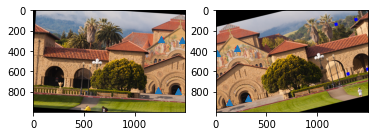

In [ ]:
# notice in these arrays, X is in 1st row (row 0)
# and Y is in 2nd row (row 1)
# the 3rd/last row (row 2) are just 1s, 
# which will be cleared later.
reds_0 = np.array([[1265.332, 1464.901, 1232.511, 1432.079],
 [ 283.361, 296.49, 782.282, 795.411],
 [   1.,       1.,       1.,       1.,   ]])
reds_1 = np.array([[ 10.95,  205.406, 127.854, 322.311],
 [420.596, 373.834, 906.737, 859.975],
 [  1.,      1.,      1.,      1.   ]])
fig, (plt0, plt1) = plt.subplots(1, 2)
plt0.imshow(img_0)
plt0.scatter(x=reds_0[0, :], y=reds_0[1, :], marker="^")
plt1.imshow(img_1)
plt1.scatter(x=reds_1[0, :], y=reds_1[1, :], marker="^")

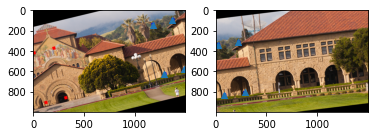

In [ ]:
blues_1 = np.array([[1177.689, 1372.146, 1294.594, 1489.05 ],
 [ 140.025,   93.263,  626.166,  579.404],
 [   1.,       1.,       1.,       1.,   ]])
blues_2 = np.array([[ 24.865, 223.391,  85.451, 283.978],
 [336.663, 312.429, 832.979, 808.744],
 [  1.,      1.,      1.,      1.,   ]])
fig, (plt1, plt2) = plt.subplots(1, 2)
plt1.imshow(img_1)
plt1.scatter(x=blues_1[0, :], y=blues_1[1, :], marker="^")
plt2.imshow(img_2)
plt2.scatter(x=blues_2[0, :], y=blues_2[1, :], marker="^")


#### Step 2

အဆင့် ၂ မှာ `img_0` to `img_1` transformation အတွက် အောက်က အီကွေးရှင်းမှာ $M_{0\rightarrow1}$ ရအောင် အဖြေထုတ်ရမယ်

$$M_{0\rightarrow1}V_0=V_1$$

where ...

$$V_0 = \left(\begin{array}{cc} 
1265.332 & 1464.901 & 1232.511 & 1432.079 \\
283.361 & 296.49 & 782.282 & 795.411 \\
1 & 1 & 1 & 1 
\end{array}\right)$$

and 

$$V_1 = \left(\begin{array}{cc} 
10.95 & 205.406 & 127.854 & 322.311 \\
420.596 & 373.834 & 906.737 & 859.975 \\
1 & 1 & 1 & 1
\end{array}\right)$$

> သေချာ သတိထားကြည့်ရင် $V_0$ နဲ့ $V_1$ ဆိုတာ `img_0` နဲ့ `img_1` တို့က အနီစက်တွေရဲ့ တွေကို အောက်မှာ တွေချည်းပါတဲ့ တခု ကပ်ထားတာပဲဆိုတာ မြင်လိမ့်မယ်

> Notice also that $M$ is a 3x3 matrix.

ဒီ ပုစ္ဆာကို [`estimateAffine2D`](https://amroamroamro.github.io/mexopencv/matlab/cv.estimateAffine2D.html) နဲ့ [`estimateAffinePartial2D`](http://amroamroamro.github.io/mexopencv/matlab/cv.estimateAffinePartial2D.html) တို့ကိုသုံးပြီး လွယ်လွယ်လေး ဖြေရှင်းနိုင်ပါတယ်

In [ ]:
# Notice the estimateAffinePartial2D/estimateAffine2D requires only X and Y (no third row)
# also, it expects a transpose of these matrices.
M_0_to_1, _ = cv2.estimateAffine2D(reds_0[0:2,:].T, reds_1[0:2, :].T)
M_0_to_1

array([[ 9.54837656e-01,  2.97128667e-01, -1.28143183e+03],
       [-2.97131526e-01,  9.54837858e-01,  5.26002330e+02]])

ပိုပြီး သေချာအောင်လို့ ရလာတဲ့ transformation Matrix နဲ့ `img_0` က အနီစက်တွေကို transform လုပ်ပြီး `img_1` မှာ ထပ်ကြည့်မယ်။

> `estimateAffine2D` က ထုတ်ပေးလိုက်တဲ့ `M_0_to_1` က 2x3 Matrix ဖြစ်နေတာမို့ အောက်မှာ `numpy.vstack` သုံးပြီး [0, 0, 1] ပေါ် ဆင့်ပေးရတာ သတိထားပါ။

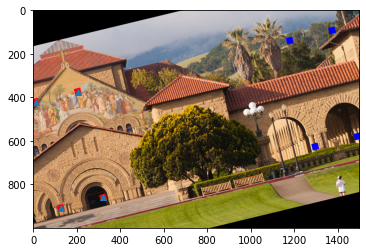

In [ ]:
transformed_reds_0 = np.vstack((M_0_to_1, [0, 0, 1])) @ reds_0
plt.imshow(img_1)
plt.scatter(x=transformed_reds_0[0, :], y=transformed_reds_0[1, :], marker="^")

တထပ်တည်းဖြစ်တာကို တွေ့ရလိမ့်မယ်။

အလားတူပဲ `img_2` က အပြာစက် ၄ စက်ကိုလဲ `img_1` ရဲ့ coordinate system ကို ရောက်‌အောင် transformation Matrix `M_2_to_1` ကို ရှာပြီး မြှောက်ကြည့်ကြမယ်၊

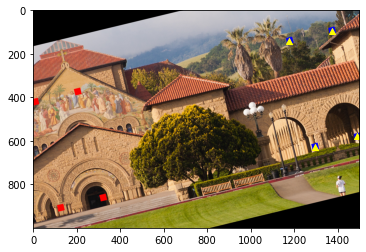

In [ ]:
M_2_to_1, _ = cv2.estimateAffine2D(blues_2[0:2, :].T, blues_1[0:2, :].T)
transformed_blues_2 = np.vstack((M_2_to_1, [0, 0, 1])) @ blues_2
plt.imshow(img_1)
plt.scatter(
    x=transformed_blues_2[0, :], 
    y=transformed_blues_2[1, :], 
    marker="^", color="yellow"
)

#### Step 3

Transformation Matrices တွေ ရလာပြီဆိုတော့ `img_0` နဲ့ `img_2` တို့ကို အဲဒီ transformation Matrices တွေနဲ့ trasnfrom လုပ်ပြီး `img_1` ပေါ်မှာ ထပ်ရုံပဲပေါ့။

တနည်းအားဖြင့် 

$$V_{0\rightarrow1}I_0$$

where

$$I_0$$ is Matrix of all points in `img_0`

အဲဒီလိုလုပ်ဖို့ `warpAffine` function ကို အသုံးပြုနိုင်တယ်။

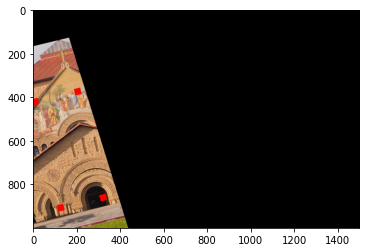

In [ ]:
# this will result in majorly BLACK image
# it is because most of img_0 goes to negative space
# of img_1 coordinate system
img_0_t = cv2.warpAffine(img_0, M_0_to_1, (WIDTH, HEIGHT))
plt.imshow(img_0_t)

အပေါ်က ပုံက **ပြတ်**နေတာကို တွေ့ရလိမ့်မယ်။ ဒါဘာကြောင့်လဲဆိုတော့ `img_1` ရဲ့ coordinate system မှာ `img_0_t` က တဝက်တပြက်ပဲ ‌ပေါ်ပြီး အပြင်ထွက်နေလို့ ဖြစ်တယ်။

ဒါကို ‌ဖြေရှင်းဖို့ ပုံ ၃ ပုံလုံးရဲ့ ထောင့်စွန်းတွေကို `img_1` ရဲ့ coordinate system ကို map လုပ်ပြီး `min_y` နဲ့ `min_x` တို့ကို (0, 0) ဖြစ်တဲ့အထိ ညာဘက်နဲ့ အောက်ဘက် (Y axis ဇောက်ထိုးဖြစ်နေတာမို့) ကို တွန်းရမယ်။ 

တွန်းတာကို translate operation လို့ ခေါ်ပြီး အောက်ကပြထားတဲ့ Translation Matrix နဲ့ ဘယ်ဘက်က မြှောက်ခြင်းဖြင့် ရရှိနိုင်တယ်။

$$M_{\text{translate}} = \left(\begin{array}{cc}
1 & 0 & -x_{\text{min}}\\
0 & 1 & -y_{\text{min}}\\
0 & 0 & 1
\end{array}\right)$$

ဒီတော့ လုပ်ရမဲ့ operation က 

$$M_{\text{translate}}M_{0\rightarrow1}I_0$$

ဖြစ်သွားတယ်။

Matrix တွေ မြှောက်တာဟာ associated (ဖက်စပ်ရ) ဖြစ်တာမို့ $M_{\text{translate}}M_{0\rightarrow1}$ ကို အရင်လုပ်နိုင်ပါတယ်။

In [ ]:
img_extremes = np.array([
  [0, 0, WIDTH, WIDTH],
  [0, HEIGHT, 0, HEIGHT],
  [1, 1, 1, 1]
])
# extreme 4 points of each img in img_1's coordinate system
img_0_extremes = np.vstack((M_0_to_1, [0, 0, 1])) @ img_extremes
img_1_extremes = img_extremes.copy()
img_2_extremes = np.vstack((M_2_to_1, [0, 0, 1])) @ img_extremes

extreme_X = np.hstack((
    img_0_extremes[0, :], img_1_extremes[0, :], img_2_extremes[0, :]
))
extreme_Y = np.hstack((
    img_0_extremes[1, :], img_1_extremes[1, :], img_2_extremes[1, :]
))

min_x, max_x = np.min(extreme_X), np.max(extreme_X)
min_y, max_y = np.min(extreme_Y), np.max(extreme_Y)
t_x = -min_x
t_y = -min_y
final_width = max_x - min_x
final_height = max_y - min_y

t_x, t_y, final_width, final_height

(1281.4318265679642, 363.0013598322158, 4000.392846152241, 1843.8415471166409)

In [ ]:
# computing the M_translate x M_x_to_1 first
M_t = np.array([
  [1, 0, t_x],
  [0, 1, t_y],
  [0, 0, 1]
])
M_0_to_1_adjust = M_t @ np.vstack((M_0_to_1, [0, 0, 1]))
M_1_to_1_adjust = M_t
M_2_to_1_adjust = M_t @ np.vstack((M_2_to_1, [0, 0, 1]))

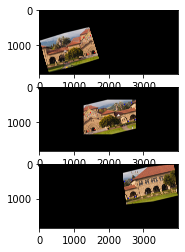

In [ ]:
# now, let's compute the transformed img_0, img_1 and img_2 again
img_0_t = cv2.warpAffine(
    img_0, M_0_to_1_adjust[0:2], (int(final_width), int(final_height))
)
img_1_t = cv2.warpAffine(
    img_1, M_1_to_1_adjust[0:2], (int(final_width), int(final_height))
)
img_2_t = cv2.warpAffine(
    img_2, M_2_to_1_adjust[0:2], (int(final_width), int(final_height))
)
fig, (plt0, plt1, plt2) = plt.subplots(3, 1)
plt0.imshow(img_0_t)
plt1.imshow(img_1_t)
plt2.imshow(img_2_t)

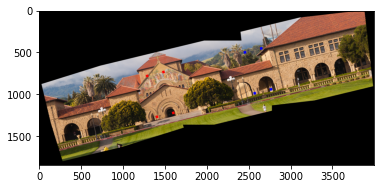

In [ ]:
# combining these 3 aligned images is a matter of
# taking max as black is all 3 color channels zero.
final_image = np.maximum(np.maximum(img_0_t, img_1_t), img_2_t)
plt.imshow(final_image)

## Expanding the Idea to 3D Space

အောက်ကပုံမှာ မျက်နှာပေါ်က landmark နေရာ 68 ခုကို ပြထားတယ်။ 

![face model=30%](https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/curious/uploads/pictures/1592469192-74364.png)

> သတိထားဖို့က 1 - 68 အထိကို 0-based indexing နဲ့ဆိုရင် 0 - 67 ဖြစ်တယ်ဆိုတာပဲ။

အရင်ဆုံး 3D point 68 point ရှိတဲ့ မျက်နှာ model ကို ရယူလိုက်ရအောင်။ 

In [ ]:
# clone this and go into its directory
!git clone https://github.com/neolaw84/yadil.git

Cloning into 'yadil'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (139/139), 47.92 MiB | 41.48 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
import sys
if "/content/yadil/" not in sys.path:
    sys.path.append("/content/yadil/")

In [ ]:
# 1st, built-ins
import requests
from io import BytesIO

# 2nd, third-parties
import numpy as np
import scipy as sp
from scipy import linalg as la

from matplotlib import pyplot as plt
from PIL import Image

import cv2

In [ ]:
from yadil.image.face_model import model_points
model_points.shape

(68, 3)

ပြီးရင် `model_points` တွေကို visualize လုပ်ကြည့်ရအောင်။

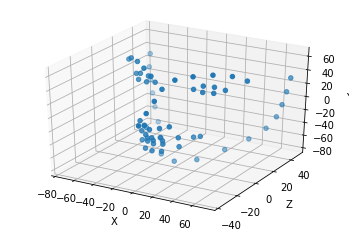

In [ ]:
def show_model_3d(points):
    ax = plt.axes(projection ="3d")
    ax.scatter3D(points[:, 0], points[:, 2], -points[:, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    plt.show()

show_model_3d(model_points)

ကျနော်တို့ဟာ Z axis ကို သိပ်စိတ်မဝင်စားပါဘူး။ ဒါကြောင့် ဖြတ်ထုတ်လိုက်ပါမယ်။

> သေချာကြည့်ရင် `model_points` ရဲ့ coordinate system ဟာ (0, 0) ကို ဗဟိုပြုပြီး မျက်နှာအပေါ်တခြမ်းက Y values တွေဟာ -ive, နောက်အောက်ဘက်တခြမ်းက Y values တွေဟာ +ive ဖြစ်နေတာ တွေ့ရပါလိမ့်မယ်။ အလားတူပဲ ဘယ်ခြမ်း (ကင်မရာဘက်က ကြည့်ရင် ဘယ်) က X values တွေဟာ -ive ဖြစ်ပြီး ညာခြမ်းက X values တွေဟာ +ive ဖြစ်နေတာကို တွေ့ရပါလိမ့်မယ်။

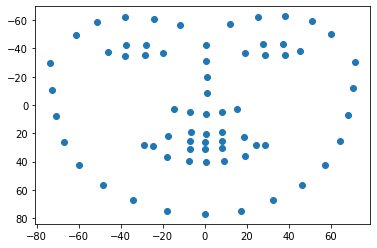

In [ ]:
plt.gca().invert_yaxis()
plt.scatter(x=model_points.T[0], y=model_points.T[1])

အောက်က ပုံကတော့ နှုတ်ခမ်းမွှေးပုံပါ။ နှုတ်ခမ်းမွှေးရဲ့ coordinate system ကို သတိထားကြည့်ပါ။

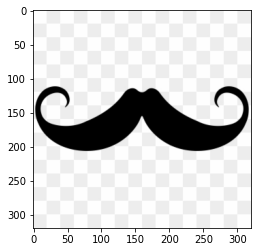

In [ ]:
r = requests.get("https://i.ibb.co/hBX7Dpf/mustache.jpg")
with BytesIO(r.content) as f:
  raw_img = Image.open(f)
  img_mask = np.array(raw_img)
# img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGBA)
plt.imshow(img_mask)

In [ ]:
model_points.shape

(68, 3)

In [ ]:
V_mustache = np.array([
  [155, 125, 1],
  [50, 200, 1],
  [275, 200, 1]
]).T
V_model_points = np.vstack((np.hstack((
    model_points[33, 0:2].reshape(2, -1), 
    model_points[48, 0:2].reshape(2, -1), 
    model_points[54, 0:2].reshape(2, -1)
)), [1, 1, 1]))

V_landmarks = np.vstack((np.hstack((
    landmark[33, 0:2].reshape(2, -1), 
    landmark[48, 0:2].reshape(2, -1), 
    landmark[54, 0:2].reshape(2, -1)
)), [1, 1, 1]))

M_m_to_mp, _ = cv2.estimateAffinePartial2D(V_mustache[0:2].T, V_model_points[0:2].T)
M_m_to_mp

array([[ 2.85184139e-01,  6.29529663e-03, -4.44345337e+01],
       [-6.29529663e-03,  2.85184139e-01, -2.81093464e+01]])

နောက်ဆုံးပုံက Tom Holland ရဲ့ ပုံပါ။ ဒီပုံရဲ့ coordinate system ကိုလဲ သတိထားကြည့်ပါဦး။

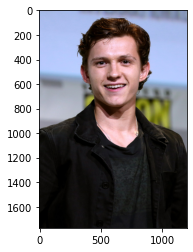

In [ ]:
r = requests.get("https://i.ibb.co/5WNdy1R/1200px-Tom-Holland-by-Gage-Skidmore.jpg")
with BytesIO(r.content) as f:
  raw_img = Image.open(f)
  img_actor = np.array(raw_img)
# img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGBA)
plt.imshow(img_actor)

အောက်က cell နှစ်ခုကတော့ **machine learning model** ကို သုံးပြီး Tom Holland ပုံက သူ့မျက်နှာရဲ့ coordinate `landmark` တွေကို ရယူတာပါ။ 

> ပထမဆုံး တကြိမ်ဆို ML model download လုပ်ရလို့ run တာ နည်းနည်းကြာပါမယ်။

In [ ]:
%pip install -U insightface onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 433 kB 5.9 MB/s 
     |████████████████████████████████| 5.2 MB 58.6 MB/s 
     |████████████████████████████████| 12.8 MB 41.8 MB/s 
     |████████████████████████████████| 631 kB 54.8 MB/s 
  Created wheel for insightface: filename=insightface-0.6.2-cp37-cp37m-linux_x86_64.whl size=983291 sha256=170aa36c62a3ebecd22705109e295f5ed4440f79d44011e36f992b286dd99ec7
  Stored in directory: /root/.cache/pip/wheels/ae/2f/ee/b7883684f81f184dc1e571424108144d3cf7716290f04781c0
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=62d7c386c39d183e70323f0d7d31ceaece9b9f46bd7b8500d961838869925937
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built insightface imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling 

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [04:34<00:00, 1025.12KB/s]
/usr/local/lib/python3.7/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names)))
/usr/local/lib/python3.7/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names)))


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


/usr/local/lib/python3.7/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


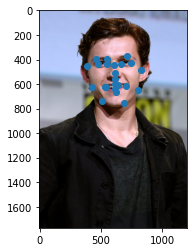

In [ ]:
from insightface.app import FaceAnalysis
app = FaceAnalysis(allowed_modules=["detection", "genderage", "landmark_3d_68"], providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))
faces = app.get(img_actor)
f = faces[0]
landmark = f["landmark_3d_68"]
plt.imshow(img_actor)
# draw only 1/3 of the landmarks because the markers are large
plt.scatter(x=landmark.T[0,::3], y=landmark.T[1,::3])

### Make it a program

Programmer တယောက်လို စဉ်းစားကြည့်ရအောင်ပါ။ 

* လိုချင်တဲ့ ရလဒ်က မင်းသားပုံကို နှုတ်ခမ်းမွှေးတပ်ချင်တာပါ။ 

* ဒါပေမဲ့ မင်းသားပုံက ဘယ်သူ့ကို ဘယ်ထောင့်က ရိုက်ထားတဲ့ပုံလာမလဲ မသိပါဘူး။ 

* ဒီတော့ ML model နဲ့ `landmark` တွေထုတ်ပြီး ပြောင်းနေတဲ့ landmark တွေကို မူတည်ပြီး နှုတ်ခမ်းမွှေးကို ရွှေ့ရမှာပါ။ ရွှေ့ရုံမကသေးပါဘူး၊ မျက်နှာက ပုံထဲမှာ သေးနေရင် နှုတ်ခမ်းမွှေးကို သေး၊ မျက်နှာက ပုံထဲမှာ ကြီးနေရင် နှုတ်ခမ်းမွှေးကို ကြီး၊ မျက်နှာက ဘေးစောင်းနေရင် နှုတ်ခမ်းမွှေးကို ဘေးလိုက်စောင်းရမှာပါ။ 

* ဖြစ်နိုင်တာတွေ ချရေးကြည့်ရင် ... 

  * နှုတ်ခမ်းမွှေးကို `model_points` ရဲ့ coordinate system ကို ရွှေ့/ချုံ့/ချဲ့/လှည့်လို့ရတယ်။ ရွှေ့/ချုံ့/ချဲ့/လှည့်တဲ့ Transformation Matrix $M_1$ ကို `estimateAffinePartial2D` သုံးပြီး ရှာလို့ရတယ်။ 

  * `model_points` ကို အရှင် (variable) လာတဲ့ မင်းသားပုံရဲ့ coordinate system ကို ရွှေ့/ချုံ့/ချဲ့/လှည့်လို့ရတယ်။ ရွှေ့/ချုံ့/ချဲ့/လှည့်တဲ့ Transformation Matrix $M_2$ ကို `estimateAffinePartial2D` သုံးပြီး ရှာလို့ရတယ်။ (68 point ထဲက တတန်းတည်း ဖြစ်မနေတဲ့ ကြိုက်ရာ 3-4 point ယူပြီး ရှာပါ။)

  * Matrix တွေမြှောက်တာ commutative ရော၊ associative ပါဖြစ်တယ်။ ဒီတော့ ပုံတပုံ (နှုတ်ခမ်းမွှေးပဲထားပါတော့) ကို `warpAffine` နဲ့ Transformation $M_1$ apply ပြီး နောက်တခါ `warpAffine` နဲ့ Transformation $M_2$ apply တာနဲ့ `warpAffine` နဲ့ တခါတည်း $M_2 \times M_1$ ကို apply တာနဲ့ တူတယ်။

ဒါဆိုရင် ... ဘယ်သူ့ပုံလာလာ ... `landmark` ရှာပြီး နှုတ်ခမ်းမွှေးတပ်တဲ့ program ကို ရေးလို့ရနိုင်ပါပြီ။ စမ်းရေးကြည့်ပါ။

> တကယ်က 3D အစစ်ဖြစ်သွားရင် (Z axis နဲ့ rotation လိုမျိုး perspective ပါလာရင်) Affine နဲ့ မရတော့ဘူး၊ **homography** ဆိုတဲ့ $3 \times 3 $ Matrix ကို ရှာရတယ်။ ဒါပေမဲ့ တော်ရုံရှေ့က ရိုက်တဲ့ပုံအများစုကတော့ Affine နဲ့တင် ရတယ်။ သိချင်ရင်တော့ ရှာဖတ်ကြည့်ပေါ့။

# Appendix : Don't look beyond this

In [ ]:
# 250 x 1250, 250 x 1450, 750 x 1250, 750 x 1450
original_reds = np.array([
  [1250, 250, 1],
  [1450, 250, 1],
  [1250, 750, 1],
  [1450, 750, 1]
]).T
original_blues = np.array([
  [2450, 250, 1],
  [2650, 250, 1],
  [2450, 750, 1],
  [2650, 750, 1]
]).T
reds_0 = (np.vstack((M_Rotate_0, [0, 0, 1])) @ original_reds) - np.array([[0, 0, 0]]).T
reds_1 = (np.vstack((M_Rotate_1, [0, 0, 1])) @ original_reds) - np.array([[1200, 0, 0]]).T
blues_1 = (np.vstack((M_Rotate_1, [0, 0, 1])) @ original_blues) - np.array([[1200, 0, 0]]).T
blues_2 = (np.vstack((M_Rotate_2, [0, 0, 1])) @ original_blues) - np.array([[2400, 0, 0]]).T

with np.printoptions(precision=3, suppress=True):
  print(reds_0)
  print(reds_1)
  print(blues_1)
  print(blues_2)

[[1265.332 1464.901 1232.511 1432.079]
 [ 283.361  296.49   782.282  795.411]
 [   1.       1.       1.       1.   ]]
[[ 10.95  205.406 127.854 322.311]
 [420.596 373.834 906.737 859.975]
 [  1.      1.      1.      1.   ]]
[[1177.689 1372.146 1294.594 1489.05 ]
 [ 140.025   93.263  626.166  579.404]
 [   1.       1.       1.       1.   ]]
[[ 24.865 223.391  85.451 283.978]
 [336.663 312.429 832.979 808.744]
 [  1.      1.      1.      1.   ]]


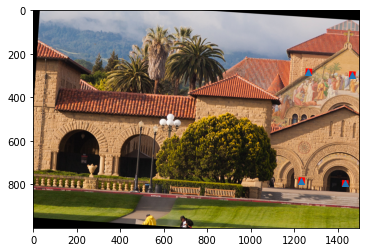

In [ ]:
plt.imshow(img_0)
plt.scatter(x = reds_0[0, :], y= reds_0[1, :], marker="^")